In [286]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import matplotlib.dates as mdates

def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

##Please bear with me as this workbook involved a good bit of jumping around and revision. 
##The writing of each block was far from linear but I have attempted to set them in a way that will be mostly easy to follow.

In [287]:
jumps = read_csv('jumpdata.csv')
pitches = read_csv('pitchdata.csv')

#just splitting data for each pitcher to make handling easier
jumpA = jumps[jumps['Pitcher']=='PitcherA'].copy()
jumpB = jumps[jumps['Pitcher']=='PitcherB'].copy()

pitchA = pitches[pitches['Pitcher']=='PitcherA'].copy()
pitchB = pitches[pitches['Pitcher']=='PitcherB'].copy()


#converting 'Date' and 'GameDate' columns to datetime for proper sorting 
##this might ultimately not be needed, as our errant dates appear to be data issue, not date sort issue
jumpA['Date'],jumpB['Date'] = pd.to_datetime(jumpA['Date']),pd.to_datetime(jumpB['Date'])
pitchA['GameDate'],pitchB['GameDate']=pd.to_datetime(pitchA['GameDate']),pd.to_datetime(pitchB['GameDate'])


#jumpA,jumpB =jumpA.sort_values(by='Date'),jumpB.sort_values(by='Date')
#pitchA,pitchB=pitchA.sort_values(by='GameDate'),pitchB.sort_values(by='GameDate')
##initially included, later revised once sorting was determined to not be our solution


daily_velo_A= pitchA.groupby('GameDate')['ReleaseSpeed'].mean().reset_index()

daily_velo_B_FB = pitchB[pitchB['PitchType']=='FB'].groupby('GameDate')['ReleaseSpeed'].mean().reset_index()
daily_velo_B_SI = pitchB[pitchB['PitchType']=='SI'].groupby('GameDate')['ReleaseSpeed'].mean().reset_index()

In [288]:
mean_jump = jumpA[jumpA['name']=='Bodyweight in Kilograms']['Value'].iloc[0:21].mean()
q1, q3 = jumpA[jumpA['name']=='Bodyweight in Kilograms']['Value'].iloc[0:21].quantile([0.25,0.75])
bounds = 1.5*(q3-q1)
print(f"Our Body Weight values are fairly consistent, with a mean value of {round(mean_jump,2)}kg. \nWe can eliminate any readings below {round(q1-bounds,2)}kg and above {round(q3+bounds,2)}kg")
#wasn't initially sure if incorrectly dated values are just sorted wrong or bad data, easier to exclude altogether
##body weight indicates trials 23/24 (.iloc[22:23]) for pA are a different subject, incorrectly sorted
###beyond eye test, here's simple mathematical justification for excluding said trials as outliers

errant_dates = jumpA[(jumpA['name'] == 'Bodyweight in Kilograms') &((jumpA['Value'] > 106.5) | (jumpA['Value'] < 100.5))]['Date'].unique()
jumpA_F = jumpA[~jumpA['Date'].isin(errant_dates)].copy()
#F for filtered

metrics = ['Peak Power / BM', 'RSI-modified','Jump Height (Imp-Mom)','Eccentric Braking RFD / BM']
#4 main metrics I'd like to include throughout

Our Body Weight values are fairly consistent, with a mean value of 103.52kg. 
We can eliminate any readings below 101.04kg and above 106.0kg


In [346]:
avg_FB = round(pitchB[pitchB['PitchType']=='FB']['ReleaseSpeed'].mean(), 2)
avg_SI = round(pitchB[pitchB['PitchType']=='SI']['ReleaseSpeed'].mean(),2)
avg_pB = round(pitchB['TotalOutingPitches'].mean(),2)
print(f"Pitcher B averages {avg_FB}mph on 4S fastballs and {avg_SI}mph on sinkers. I would like to keep these pitch types separate. \nHe also averages {avg_pB} pitches per outing.")

avg_A = round(pitchA['ReleaseSpeed'].mean(),2)
avg_pA = round(pitchA['TotalOutingPitches'].mean(),2)
print(f"Pitcher A averages {avg_A}mph on his fastballs and averages {avg_pA} pitches per outing.")

#just a bit more info, more for my reference than anything


Pitcher B averages 95.62mph on 4S fastballs and 94.13mph on sinkers. I would like to keep these pitch types separate. 
He also averages 27.03 pitches per outing.
Pitcher A averages 92.07mph on his fastballs and averages 62.47 pitches per outing.


In [368]:
ppaA = pitchA[['GameDate','TotalOutingPitches']].drop_duplicates().reset_index(drop=True)
ppaB = pitchB[['GameDate','TotalOutingPitches']].drop_duplicates().reset_index(drop=True)
#pitches per appearance
ppaA_ind = ppaA.set_index('GameDate')
ppaB_ind = ppaB.set_index('GameDate')
#ensuring we can use a time based window for pitches

ppaA_ind['MA_TOP'] = ppaA_ind['TotalOutingPitches'].rolling(window='14D', min_periods=1).sum()
ppaA=ppaA_ind.reset_index()
#want to look at total pitches over 2 (?) week windows. coming back to this later.

ppaB_ind['MA_TOP'] = ppaB_ind['TotalOutingPitches'].rolling(window='14D', min_periods=1).sum()
ppaB=ppaB_ind.reset_index()


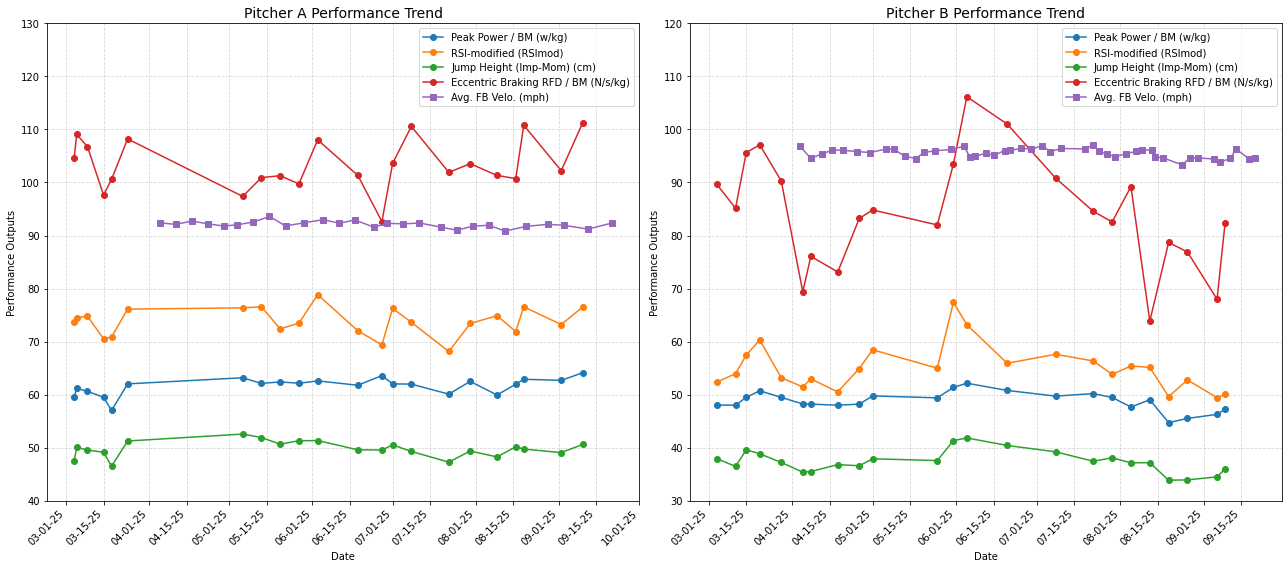

In [290]:
##this section is just made to create 2 subplots that show all 4 jump markers and pitch velo at the same time

labels = ['w/kg','RSImod','cm','N/s/kg']

fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')
axes = axes.flatten()

plot_data = [(jumpA_F, daily_velo_A, 'Pitcher A'),(jumpB, daily_velo_B_FB, 'Pitcher B')]
#while sinker velo is not quite 1-1 correlated with FB velo, I don't think adding it will provide much value to the coach


y_lims = [(40,130),(30,120)]
for i, (jump_df, velo_df, pitcher_name) in enumerate(plot_data):
    ax = axes[i]
    
    for j, name in enumerate(metrics):
        metric_data = jump_df[jump_df['name']==name]
        ax.plot(metric_data['Date'],metric_data['Value'],label=f'{name} ({labels[j]})', marker='o')
    ax.plot(velo_df['GameDate'],velo_df['ReleaseSpeed'], label='Avg. FB Velo. (mph)', marker='s')
    
    ax.set_title(f'{pitcher_name} Performance Trend', fontsize=14)
    ax.set_xlabel('Date',fontsize=10)
    ax.set_ylabel('Performance Outputs',fontsize = 10)
    ax.set_ylim(y_lims[i][0],y_lims[i][1])
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')    
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

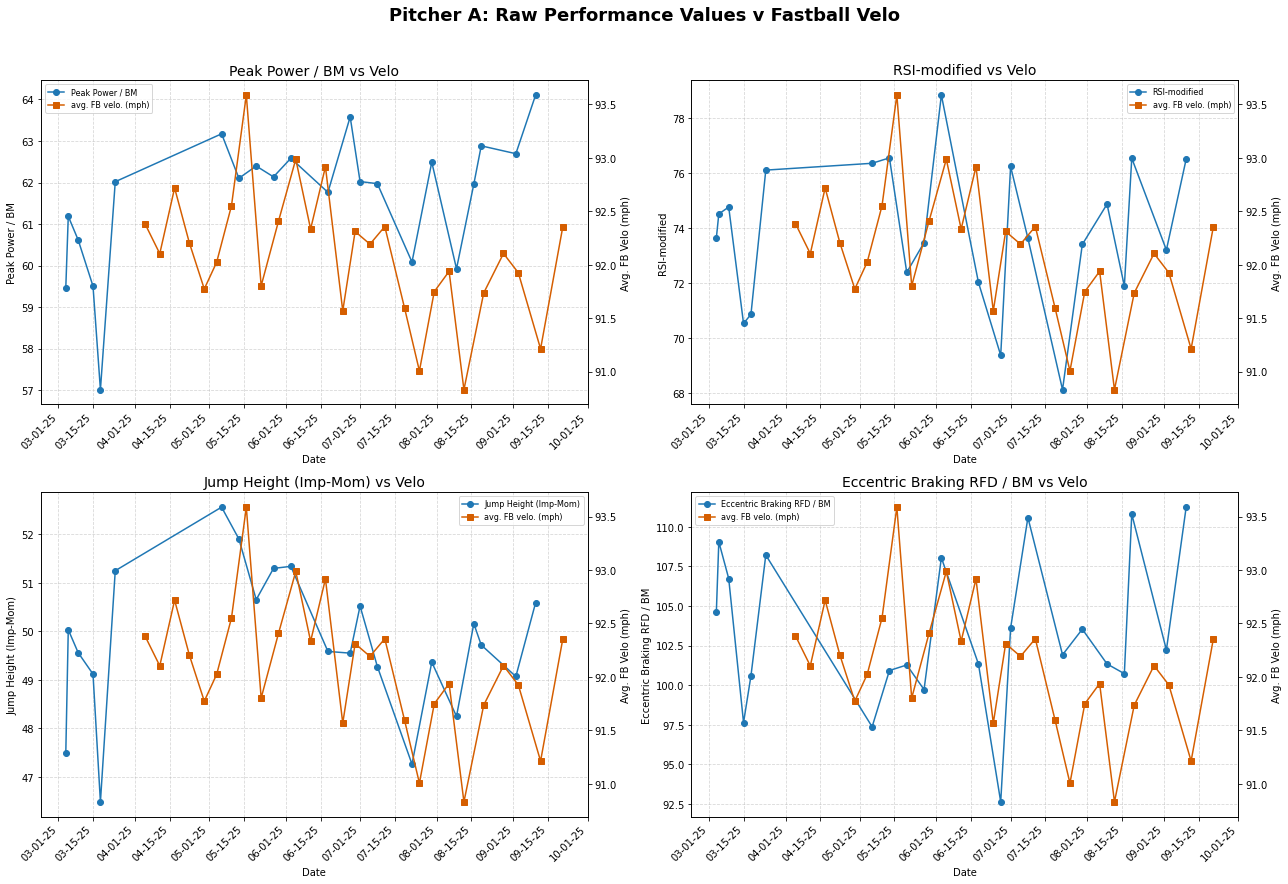

In [330]:
#now plotting each metric vs velo independently for Pitcher A

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

fig.suptitle('Pitcher A: Raw Performance Values v Fastball Velo', fontsize=18,fontweight='bold',y=1.02)

for i, name in enumerate(metrics):
    ax = axes[i]
    
    p1 = ax.plot(jumpA_F[jumpA_F['name']==name]['Date'], jumpA_F[jumpA_F['name']==name]['Value'], label=name,marker = 'o')
    ax.set_ylabel(f'{name}', fontsize=10)
    
    ax2=ax.twinx()
    #second axis allows for easier comparison of each metric
    
    p2 = ax2.plot(daily_velo_A['GameDate'],daily_velo_A['ReleaseSpeed'],label='avg. FB velo. (mph)', marker = 's',color = '#D55E00')
    
    ax2.set_ylabel('Avg. FB Velo (mph)',fontsize=10)
    
    lines = p1 + p2
    plt_labels = [l.get_label() for l in lines]
    ax.legend(lines, plt_labels, loc = 'best',fontsize = 8)
    
    
    ax.set_title(f'{name} vs Velo', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(),rotation = 45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

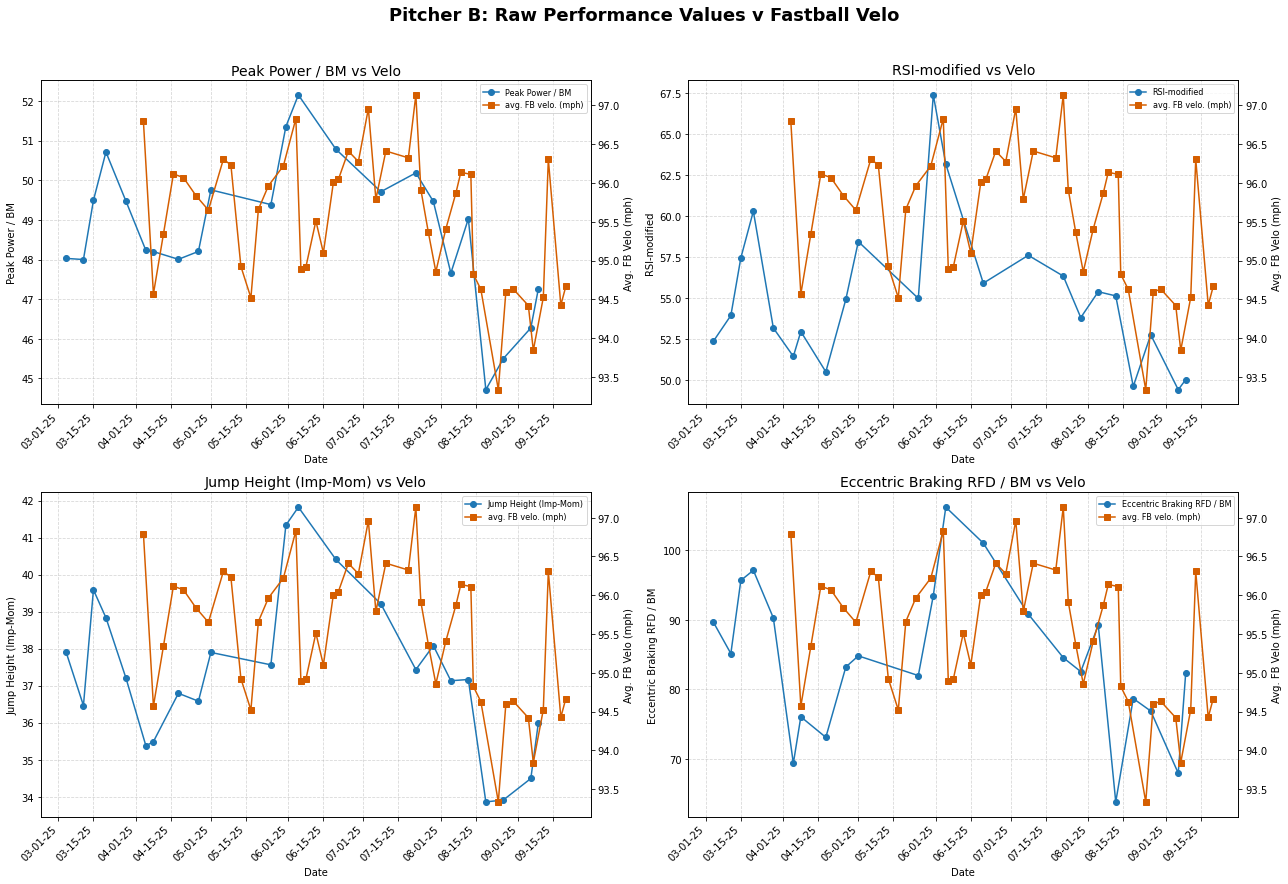

In [329]:
#and for Pitcher B


fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

fig.suptitle('Pitcher B: Raw Performance Values v Fastball Velo', fontsize=18,fontweight='bold',y=1.02)

for i, name in enumerate(metrics):
    ax = axes[i]
    
    p1 = ax.plot(jumpB[jumpB['name']==name]['Date'], jumpB[jumpB['name']==name]['Value'], label=name,marker = 'o')
    ax.set_ylabel(f'{name}', fontsize=10)
    
    ax2=ax.twinx()
    #second axis allows for easier comparison of each metric
    
    p2 = ax2.plot(daily_velo_B_FB['GameDate'],daily_velo_B_FB['ReleaseSpeed'],label='avg. FB velo. (mph)', marker = 's',color = '#D55E00')
    
    ax2.set_ylabel('Avg. FB Velo (mph)',fontsize=10)
    
    lines = p1 + p2
    plt_labels = [l.get_label() for l in lines]
    ax.legend(lines, plt_labels, loc = 'best',fontsize = 8)
    
    
    ax.set_title(f'{name} vs Velo', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(),rotation = 45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [293]:
#for more accessible data, percentage change rather than absolute values
##% change wasn't as pretty as I'd hoped, trying z score presentation

velo_diffA = daily_velo_A.copy()
velo_diffA['% Velo Diff'] = velo_diffA['ReleaseSpeed'].pct_change()*100
velo_diffA.dropna(inplace=True)



wide_jumpA =jumpA_F[jumpA_F['name'].isin(metrics)].pivot(index='Date',columns='name',values='Value')
#quick pivot to make the data easier to handle
jump_diffA = wide_jumpA.pct_change()*100
#jump_diff gives us the % change in each metric
jump_diffA = jump_diffA.reset_index().melt(id_vars=['Date'],var_name='Metric',value_name='Percent Change').dropna()
#convert back to previous format

#adding a z score column to make our percent change a bit easier to compare to velo
jump_diffA['Z-Score'] = jump_diffA.groupby('Metric')['Percent Change'].transform(lambda x: (x-x.mean())/x.std())
velo_diffA['Z-Score'] = velo_diffA['% Velo Diff'].transform(lambda x: (x-x.mean())/x.std())



##to do the same for B


velo_diffB = daily_velo_B_FB.copy()
velo_diffB['% Velo Diff'] = velo_diffB['ReleaseSpeed'].pct_change()*100
velo_diffB.dropna(inplace=True)



wide_jumpB =jumpB[jumpB['name'].isin(metrics)].pivot(index='Date',columns='name',values='Value')
#quick pivot to make the data easier to handle
jump_diffB = wide_jumpB.pct_change()*100
#jump_diff gives us the % change in each metric
jump_diffB = jump_diffB.reset_index().melt(id_vars=['Date'],var_name='Metric',value_name='Percent Change').dropna()
#convert back to previous format

#adding a z score column to make our percent change a bit easier to compare to velo
jump_diffB['Z-Score'] = jump_diffB.groupby('Metric')['Percent Change'].transform(lambda x: (x-x.mean())/x.std())
velo_diffB['Z-Score'] = velo_diffB['% Velo Diff'].transform(lambda x: (x-x.mean())/x.std())

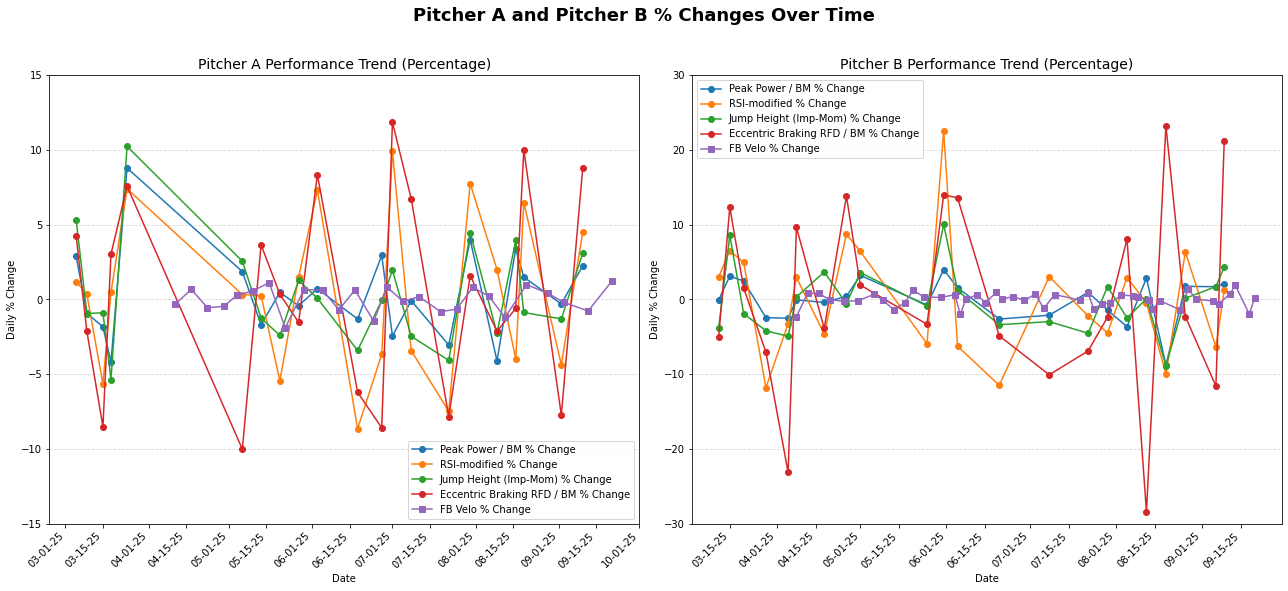

In [332]:
#this block plots pitcher A and pitcher B % daily changes in each metric 

fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')
axes = axes.flatten()



fig.suptitle('Pitcher A and Pitcher B % Changes Over Time', fontsize=18, fontweight='bold',y=1.02)
plot_data = [(jump_diffA, velo_diffA, 'Pitcher A'),(jump_diffB, velo_diffB, 'Pitcher B')]

y_lims = [(-15, 15), (-30, 30)]

for i, (jump_df, velo_df, pitcher_name) in enumerate(plot_data):
    ax = axes[i]
    
    for metric in metrics:
        metric_data = jump_df[jump_df['Metric']==metric]
        ax.plot(metric_data['Date'],metric_data['Percent Change'],label=f'{metric} % Change', marker='o')
    ax.plot(velo_df['GameDate'],velo_df['% Velo Diff'], label='FB Velo % Change', marker='s')
    
    ax.set_title(f'{pitcher_name} Performance Trend (Percentage)', fontsize=14)
    ax.set_xlabel('Date',fontsize=10)
    ax.set_ylabel('Daily % Change',fontsize = 10)
    ax.set_ylim(y_lims[i][0], y_lims[i][1])
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')    
    ax.legend(loc='best')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



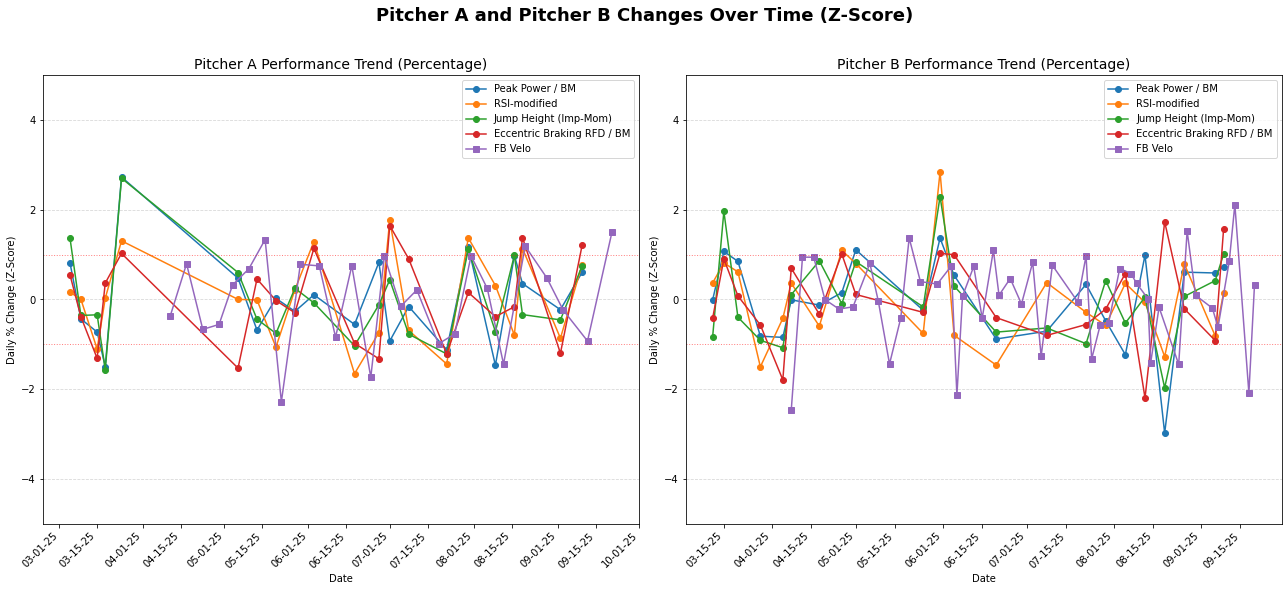

In [333]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')
axes = axes.flatten()

plot_data = [(jump_diffA, velo_diffA, 'Pitcher A'),(jump_diffB, velo_diffB, 'Pitcher B')]

y_lims = [-5,5]

fig.suptitle('Pitcher A and Pitcher B Changes Over Time (Z-Score)', fontsize=18, fontweight='bold',y=1.02)

for i, (jump_df, velo_df, pitcher_name) in enumerate(plot_data):
    ax = axes[i]
    
    for metric in metrics:
        metric_data = jump_df[jump_df['Metric']==metric]
        ax.plot(metric_data['Date'],metric_data['Z-Score'],label=f'{metric}', marker='o')
    ax.plot(velo_df['GameDate'],velo_df['Z-Score'], label='FB Velo', marker='s')
    
    ax.set_title(f'{pitcher_name} Performance Trend (Percentage)', fontsize=14)
    ax.set_xlabel('Date',fontsize=10)
    ax.set_ylabel('Daily % Change (Z-Score)',fontsize = 10)
    ax.set_ylim(y_lims[0], y_lims[1])
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')    
    ax.legend(loc='best')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.axhline(1.0, color='red', linestyle=':', linewidth=1.0, alpha=0.5)
    ax.axhline(-1.0, color='red', linestyle=':', linewidth=1.0, alpha=0.5)

plt.tight_layout()
plt.show()

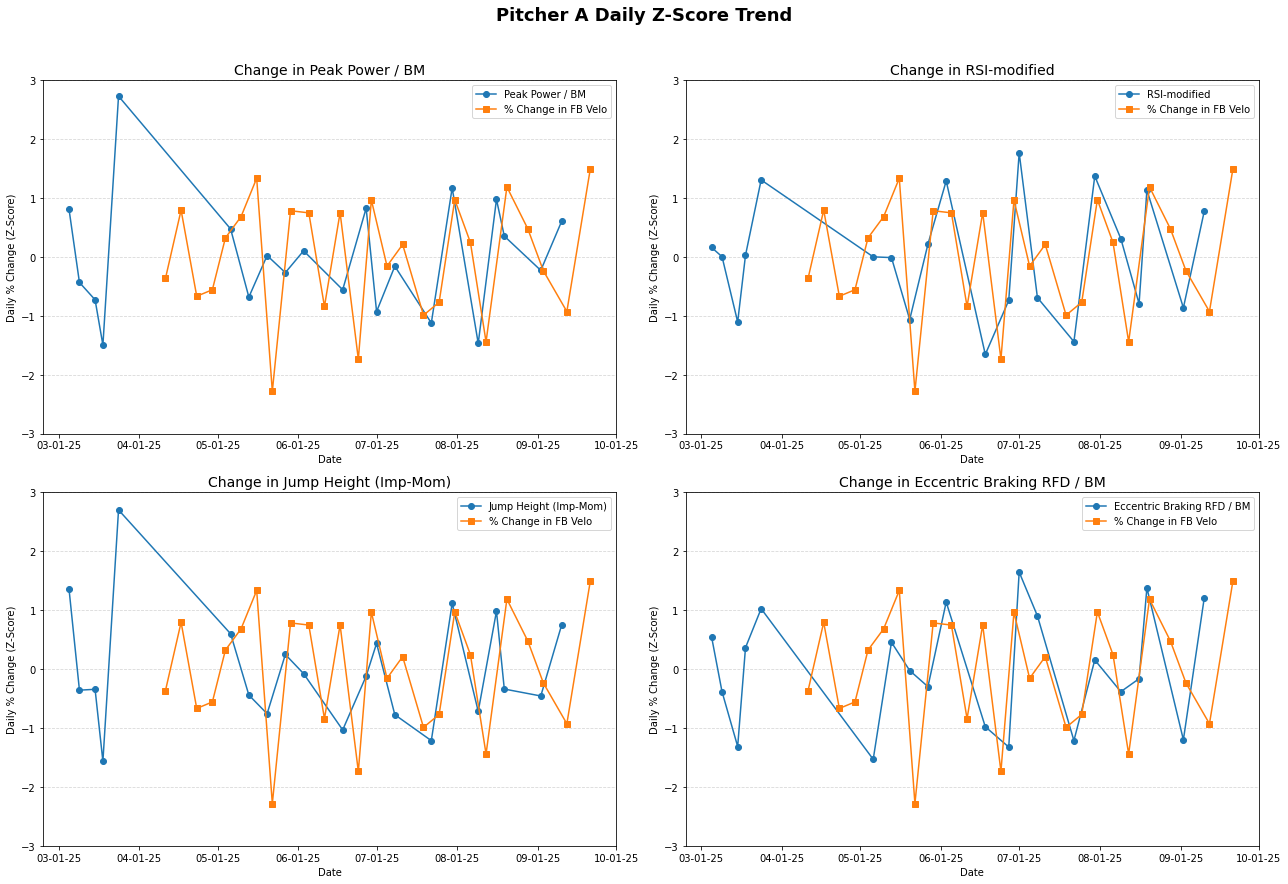

In [327]:
#now to plot each metric z-score vs velo z-score for pitcher A

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

fig.suptitle('Pitcher A Daily Z-Score Trend', fontsize=18, fontweight='bold',y=1.02)

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(jump_diffA[jump_diffA['Metric']==metric]['Date'], jump_diffA[jump_diffA['Metric']==metric]['Z-Score'], label=metric,marker = 'o')
    ax.plot(velo_diffA['GameDate'],velo_diffA['Z-Score'],label = '% Change in FB Velo', marker = 's')
    
    ax.set_title(f'Change in {metric}', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Daily % Change (Z-Score)', fontsize=10)
    ax.legend(loc='best',fontsize=10)
    
    ax.set_ylim(-3,3)
    ax.xaxis.set_major_locator(mdates.DayLocator([1]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    #plt.setp(ax.get_xticklabels(),rotation = 45, ha='right') - decided single month markers looked better here

plt.tight_layout()
plt.show()

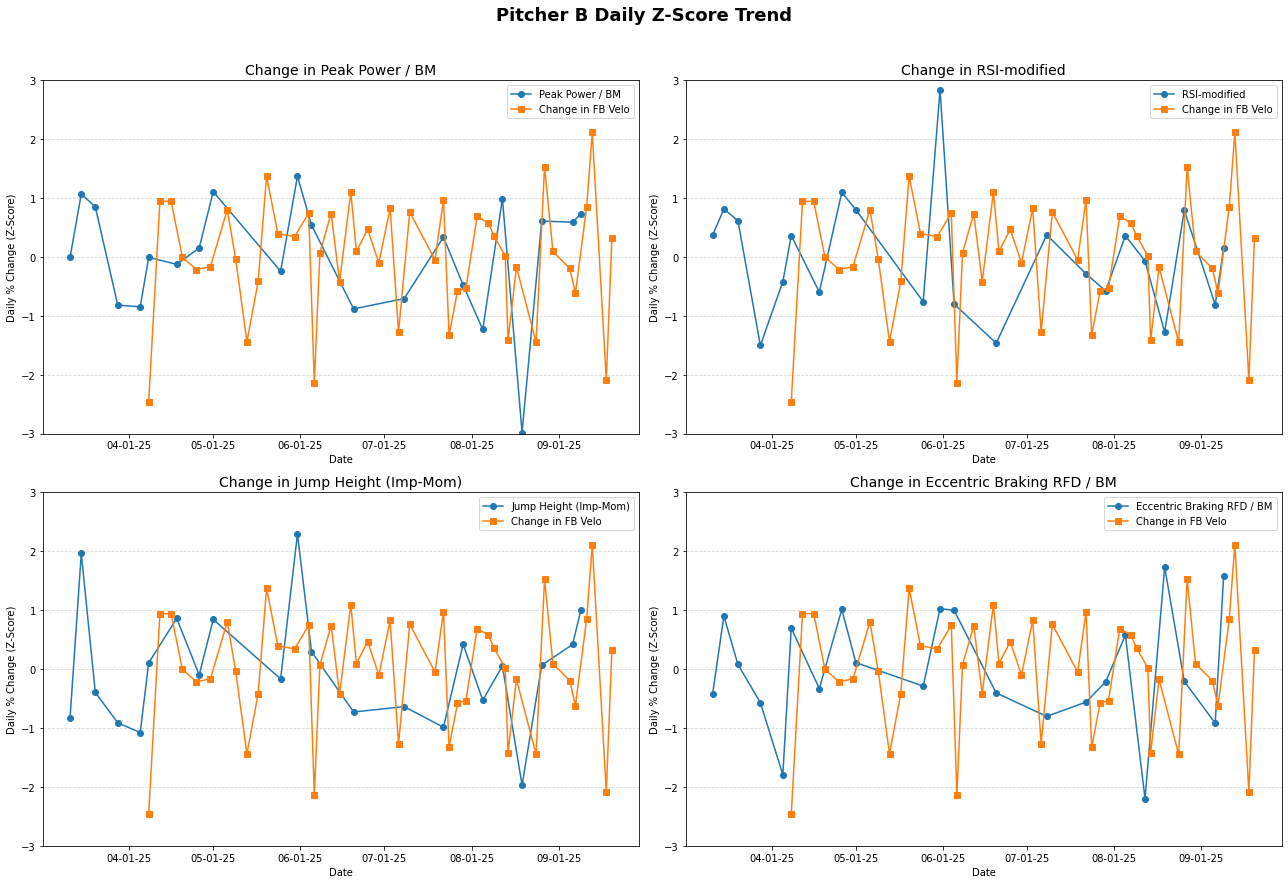

In [326]:
#same for pitcher B

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()


fig.suptitle('Pitcher B Daily Z-Score Trend', fontsize=18, fontweight='bold',y=1.02)

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(jump_diffB[jump_diffB['Metric']==metric]['Date'], jump_diffB[jump_diffB['Metric']==metric]['Z-Score'], label=metric,marker = 'o')
    ax.plot(velo_diffB['GameDate'],velo_diffB['Z-Score'],label = 'Change in FB Velo', marker = 's')
    
    ax.set_title(f'Change in {metric}', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Daily % Change (Z-Score)', fontsize=10)
    ax.legend(loc='best',fontsize=10)
    
    ax.set_ylim(-3,3)
    ax.xaxis.set_major_locator(mdates.DayLocator([1]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
  
plt.tight_layout()
plt.show()

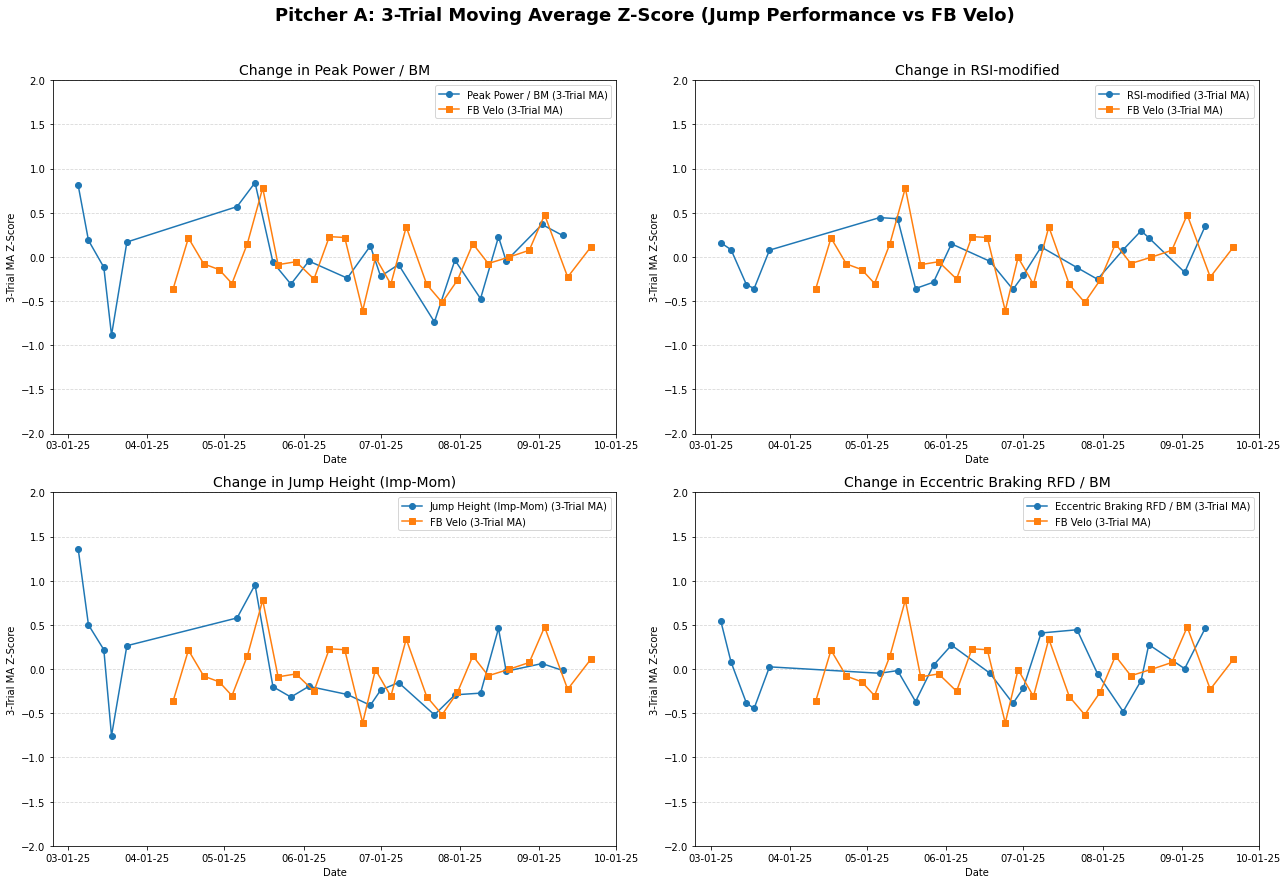

In [324]:
#now I want to do smoothed z-scores
fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

per = 3
velo_diffA['MA_ZScore'] = velo_diffA['Z-Score'].rolling(window=per, min_periods=1).mean()
jump_diffA['MA_ZScore'] = jump_diffA.groupby('Metric')['Z-Score'].rolling(window=per, min_periods=1).mean().reset_index(level=0, drop=True)

fig.suptitle('Pitcher A: 3-Trial Moving Average Z-Score (Jump Performance vs FB Velo)',fontsize=18, fontweight='bold', y=1.02)



for i, metric in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(jump_diffA[jump_diffA['Metric']==metric]['Date'], jump_diffA[jump_diffA['Metric']==metric]['MA_ZScore'], label=f'{metric} (3-Trial MA)',marker = 'o')
    ax.plot(velo_diffA['GameDate'],velo_diffA['MA_ZScore'],label = 'FB Velo (3-Trial MA)', marker = 's')
    
    ax.set_title(f'Change in {metric}', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('3-Trial MA Z-Score', fontsize=10)
    ax.legend(loc='best',fontsize=10)
    
    ax.set_ylim(-2,2)
    ax.xaxis.set_major_locator(mdates.DayLocator([1]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    

plt.tight_layout()
plt.show()

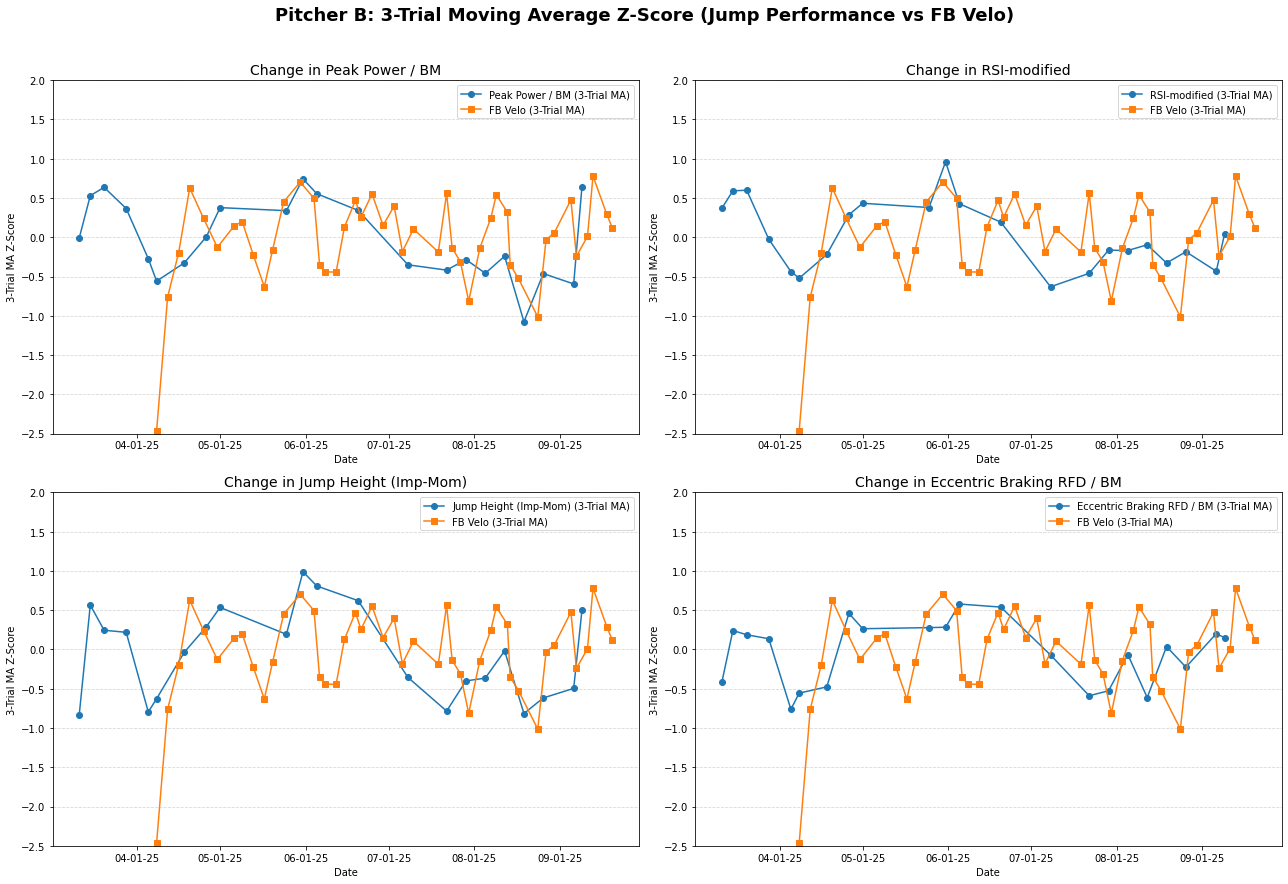

In [331]:
#now I want to do smoothed z-scores... for Pitcher B this time
fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

per = 3
velo_diffB['MA_ZScore'] = velo_diffB['Z-Score'].rolling(window=per, min_periods=1).mean()
jump_diffB['MA_ZScore'] = jump_diffB.groupby('Metric')['Z-Score'].rolling(window=per, min_periods=1).mean().reset_index(level=0, drop=True)

fig.suptitle('Pitcher B: 3-Trial Moving Average Z-Score (Jump Performance vs FB Velo)',fontsize=18, fontweight='bold', y=1.02)



for i, metric in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(jump_diffB[jump_diffB['Metric']==metric]['Date'], jump_diffB[jump_diffB['Metric']==metric]['MA_ZScore'], label=f'{metric} (3-Trial MA)',marker = 'o')
    ax.plot(velo_diffB['GameDate'],velo_diffB['MA_ZScore'],label = 'FB Velo (3-Trial MA)', marker = 's')
    
    ax.set_title(f'Change in {metric}', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('3-Trial MA Z-Score', fontsize=10)
    ax.legend(loc='best',fontsize=10)
    
    ax.set_ylim(-2.5,2)
    ax.xaxis.set_major_locator(mdates.DayLocator([1]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    

plt.tight_layout()
plt.show()

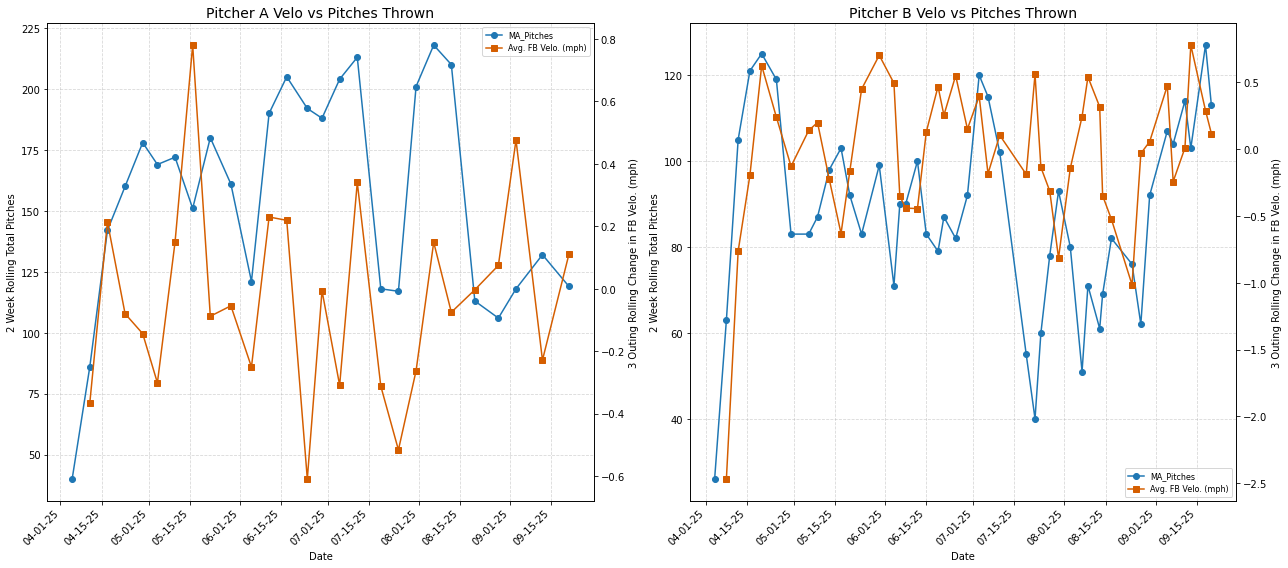

In [391]:
#2 more blocks to see if pitches thrown over 2 weeks has a strong relationship with jump output/fb velo


fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')
axes = axes.flatten()

plot_data = [(ppaA, velo_diffA, 'Pitcher A'),(ppaB, velo_diffB, 'Pitcher B')]


#y_lims = [(40,130),(30,120)]
for i, (ppa_df, velo_df, pitcher_name) in enumerate(plot_data):
    ax = axes[i]
    
    p1 = ax.plot(ppa_df['GameDate'],ppa_df['MA_TOP'], marker='o',label='MA_Pitches')
    ax.set_ylabel('2 Week Rolling Total Pitches', fontsize=10)
    
    ax2=ax.twinx()
    #second axis allows for easier comparison of each metric
    
    p2 = ax2.plot(velo_df['GameDate'],velo_df['MA_ZScore'], label='Avg. FB Velo. (mph)', marker='s',color='#D55E00')
    
    ax2.set_ylabel('3 Outing Rolling Change in FB Velo. (mph)',fontsize=10)
    
    lines = p1 + p2
    plt_labels = [l.get_label() for l in lines]
    ax.legend(lines, plt_labels, loc = 'best',fontsize = 8)
    
    
    ax.set_title(f'{pitcher_name} Velo vs Pitches Thrown', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(),rotation = 45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    
    
plt.tight_layout()
plt.show()

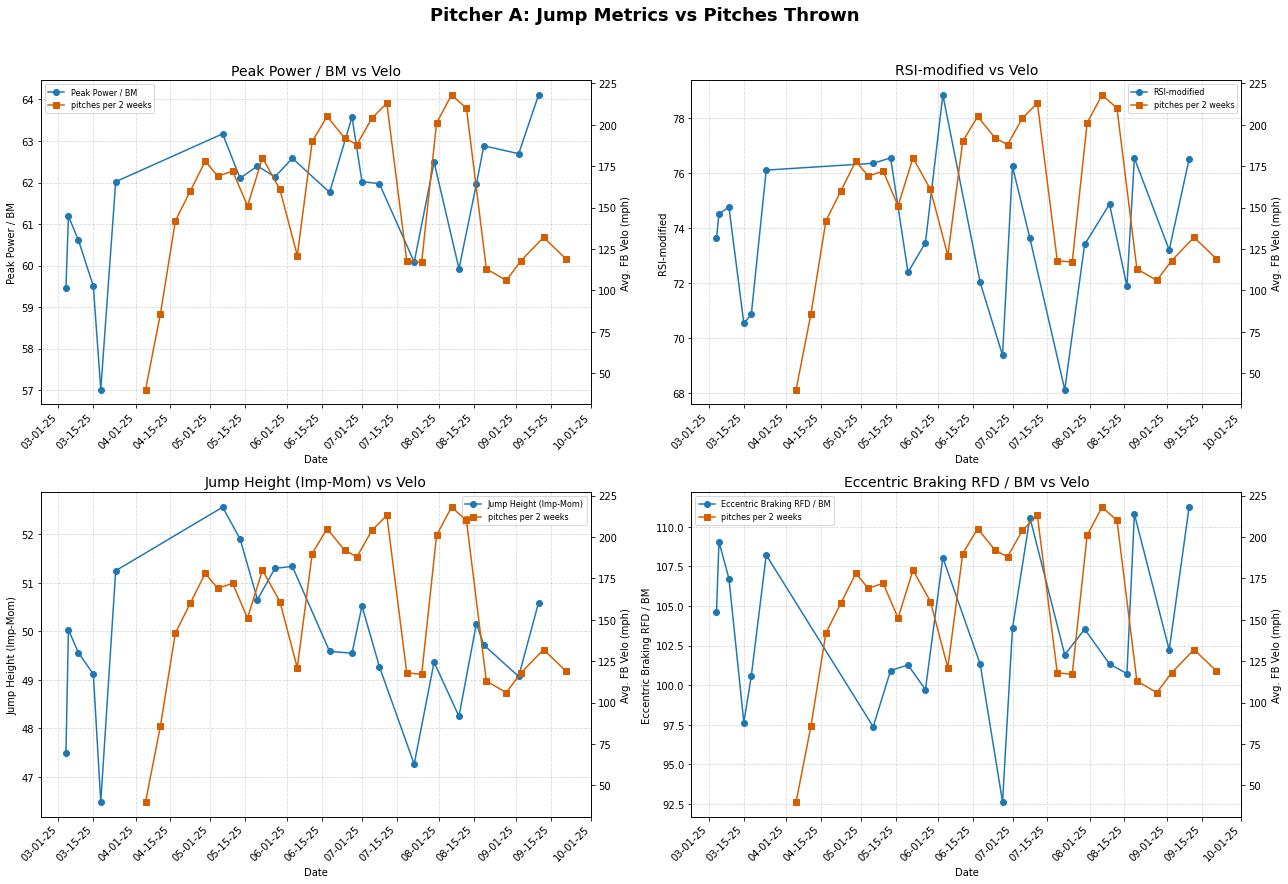

In [389]:
#now plotting each metric vs velo independently for Pitcher A

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

fig.suptitle('Pitcher A: Jump Metrics vs Pitches Thrown', fontsize=18,fontweight='bold',y=1.02)

for i, name in enumerate(metrics):
    ax = axes[i]
    
    p1 = ax.plot(jumpA_F[jumpA_F['name']==name]['Date'], jumpA_F[jumpA_F['name']==name]['Value'], label=name,marker = 'o')
    ax.set_ylabel(f'{name}', fontsize=10)
    
    ax2=ax.twinx()
    #second axis allows for easier comparison of each metric
    
    p2 = ax2.plot(ppaA['GameDate'],ppaA['MA_TOP'],label='pitches per 2 weeks', marker = 's',color = '#D55E00')
    
    ax2.set_ylabel('Avg. FB Velo (mph)',fontsize=10)
    
    lines = p1 + p2
    plt_labels = [l.get_label() for l in lines]
    ax.legend(lines, plt_labels, loc = 'best',fontsize = 8)
    
    
    ax.set_title(f'{name} vs Velo', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(),rotation = 45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

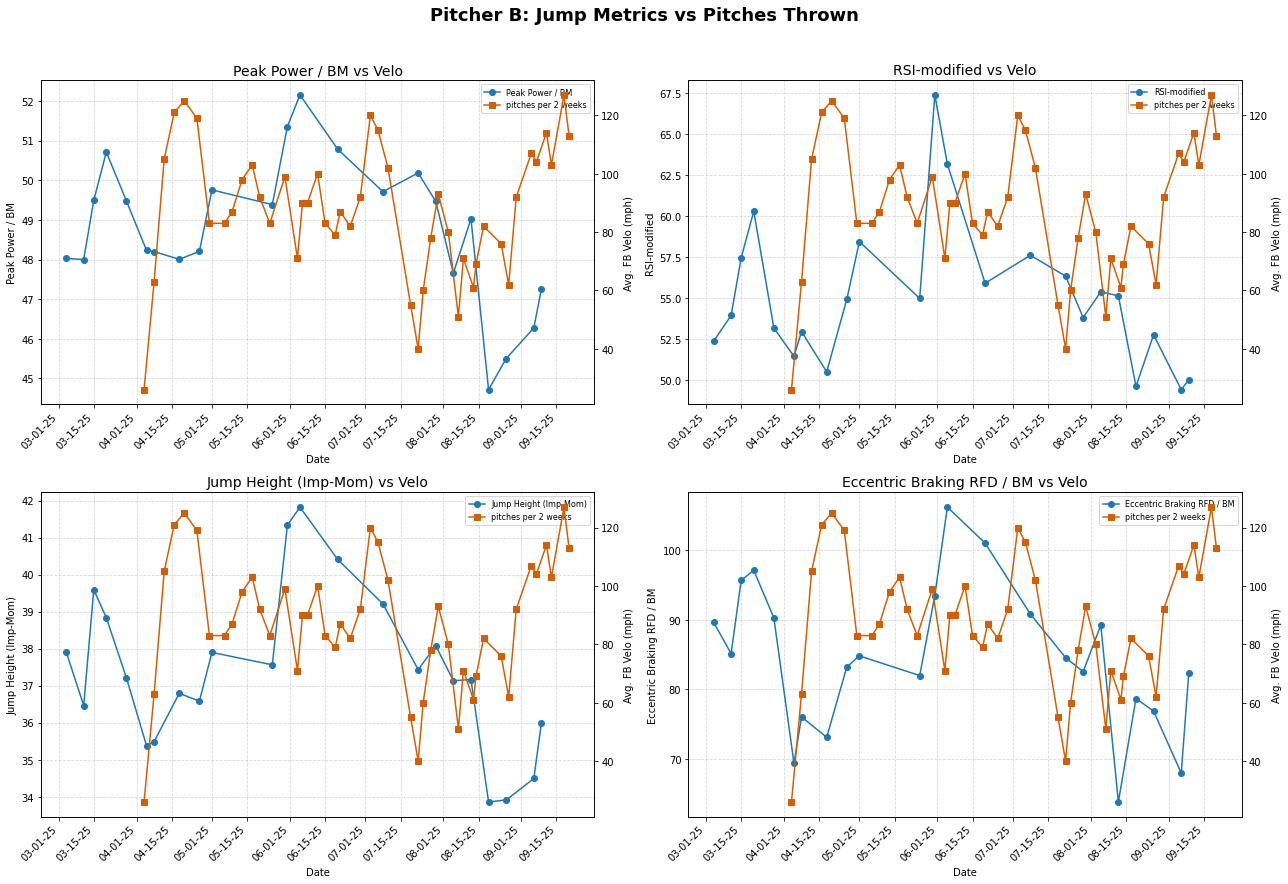

In [390]:
#now plotting each metric vs velo independently for Pitcher A

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()

fig.suptitle('Pitcher B: Jump Metrics vs Pitches Thrown', fontsize=18,fontweight='bold',y=1.02)

for i, name in enumerate(metrics):
    ax = axes[i]
    
    p1 = ax.plot(jumpB[jumpB['name']==name]['Date'], jumpB[jumpB['name']==name]['Value'], label=name,marker = 'o')
    ax.set_ylabel(f'{name}', fontsize=10)
    
    ax2=ax.twinx()
    #second axis allows for easier comparison of each metric
    
    p2 = ax2.plot(ppaB['GameDate'],ppaB['MA_TOP'],label='pitches per 2 weeks', marker = 's',color = '#D55E00')
    
    ax2.set_ylabel('Avg. FB Velo (mph)',fontsize=10)
    
    lines = p1 + p2
    plt_labels = [l.get_label() for l in lines]
    ax.legend(lines, plt_labels, loc = 'best',fontsize = 8)
    
    
    ax.set_title(f'{name} vs Velo', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    plt.setp(ax.get_xticklabels(),rotation = 45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()